In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/offline_mechanism/')

In [3]:
from utils import *

In [4]:
ds=xr.open_mfdataset('/glade/scratch/czarakas/archive/test_RAM1_002/lnd/hist/'+
                   'test_RAM1_002.clm2.h0.*.nc')

In [5]:
ds1=xr.open_mfdataset('/glade/scratch/czarakas/archive/test_RAM1_002/lnd/hist/'+
                   'test_RAM1_002.clm2.h1.*.nc')

# Method 1

In [6]:
def calculate_rah_simple(Ta, Ts, rho, SH, filter_on=False):
    Tdiff=Ts-Ta
    ra_ref=rho*CONSTANT_Cp*(Tdiff)/SH
    
    if filter_on:
        ra_ref=ra_ref.where(np.abs(SH)>5)
        #ra_ref=ra_ref.where(ra_ref>0)#.where(np.abs(Tdiff)>0.1)
    return ra_ref

In [7]:
rho=calculate_rho(ds.PBOT, ds.TBOT, ds.QBOT)
rho_highres=calculate_rho(ds1.PBOT, ds1.TBOT, ds1.QBOT)

In [8]:
rah1_highres=calculate_rah_simple(ds1.TBOT, ds1.TSKIN, rho_highres, ds1.FSH, filter_on=True)
rah1=calculate_rah_simple(ds.TBOT, ds.TSKIN, rho, ds.FSH, filter_on=True)

## Look at a map

In [9]:
actual_highres=ds1.RAM1.mean(dim='time')
est_highres=rah1_highres.mean(dim='time')
error_highres=est_highres-actual_highres

In [10]:
actual=ds.RAM1.mean(dim='time')
est=rah1.mean(dim='time')
error=est-actual

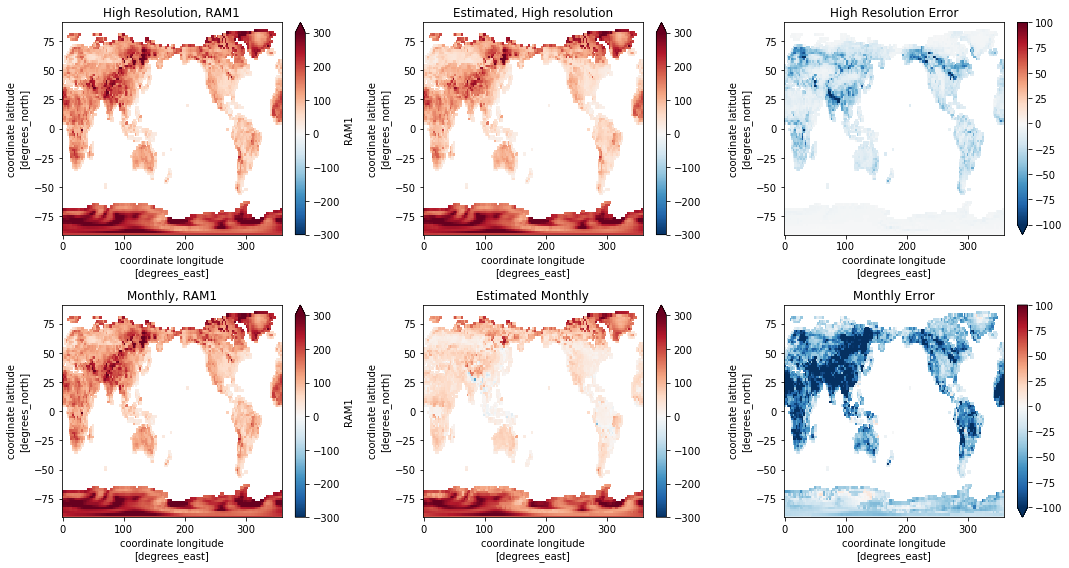

In [65]:
plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
actual_highres.plot(vmax=300, vmin=-300, cmap=plt.cm.RdBu_r)
plt.title('High Resolution, RAM1')
plt.subplot(2,3,2)
est_highres.plot(vmax=300, vmin=-300, cmap=plt.cm.RdBu_r)
plt.title('Estimated, High resolution')
plt.subplot(2,3,3)
error_highres.plot(vmax=100, vmin=-100, cmap=plt.cm.RdBu_r)
plt.title('High Resolution Error')
plt.subplot(2,3,4)
actual.plot(vmax=300, vmin=-300, cmap=plt.cm.RdBu_r)
plt.title('Monthly, RAM1')
plt.subplot(2,3,5)
est.plot(vmax=300, vmin=-300, cmap=plt.cm.RdBu_r)
plt.title('Estimated Monthly')
plt.subplot(2,3,6)
error.plot(vmax=100, vmin=-100, cmap=plt.cm.RdBu_r)
plt.title('Monthly Error')

plt.tight_layout()

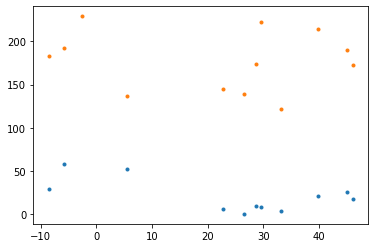

In [61]:
plt.plot(ds.FSH[:,72,110],
         rah1[:,72,110],'.')
plt.plot(ds.FSH[:,72,110],
         ds.RAM1[:,72,110],'.')

## Look at a single point

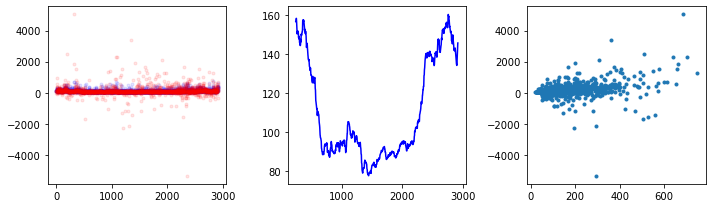

In [39]:
i=70
j=100
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.plot(ds1.RAM1[:,i,j,],'.b',alpha=0.1)
plt.plot(ds1.RAM1[:,i,j,].load().rolling(time=8*30).mean(),'-b')
plt.plot(rah1_highres[:,i,j,],'.r',alpha=0.1)
plt.plot(rah1_highres[:,i,j,].load().rolling(time=8*30).mean(),'-r')

plt.subplot(1,3,2)
plt.plot(ds1.RAM1[:,i,j,].load().rolling(time=8*30).mean(),'-b')
plt.plot(rah1_highres[:,i,j,].load().rolling(time=8*30).mean(),'-r')

plt.subplot(1,3,3)
plt.plot(ds1.RAM1[:,i,j,],
         rah1_highres[:,i,j,],'.')
plt.tight_layout()

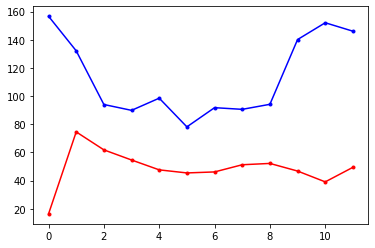

In [51]:
i=70
j=100
plt.plot(ds.RAM1[:,i,j,],'.-b', label='Actual')
plt.plot(rah1[:,i,j,],'.-r', label='Estimated')
#plt.ylim([0,200])

# Method 2

In [50]:
def calculate_rah_from_tau(TAUX, TAUY, WIND, rho, filter_on=False):
    Tau_all=np.sqrt((TAUX*TAUX)+(TAUY*TAUY))
    ra_est=(rho*WIND/Tau_all)
    #if filter_on:
   #     ra_est=ra_est.where(Tau_all>=0.1)
    return ra_est

In [51]:
rho=calculate_rho(ds.PBOT, ds.TBOT, ds.QBOT)
rho_highres=calculate_rho(ds1.PBOT, ds1.TBOT, ds1.QBOT)

In [52]:
rah2=calculate_rah_from_tau(ds.TAUX, ds.TAUY, ds.WIND, rho, filter_on=True)
rah2_highres=calculate_rah_from_tau(ds1.TAUX, ds1.TAUY, ds1.WIND, rho_highres, filter_on=True)

In [53]:
actual_highres=ds1.RAM1.mean(dim='time')
est_highres=rah2_highres.mean(dim='time')
error_highres=est_highres-actual_highres

actual=ds.RAM1.mean(dim='time')
est=rah2.mean(dim='time')
error=est-actual

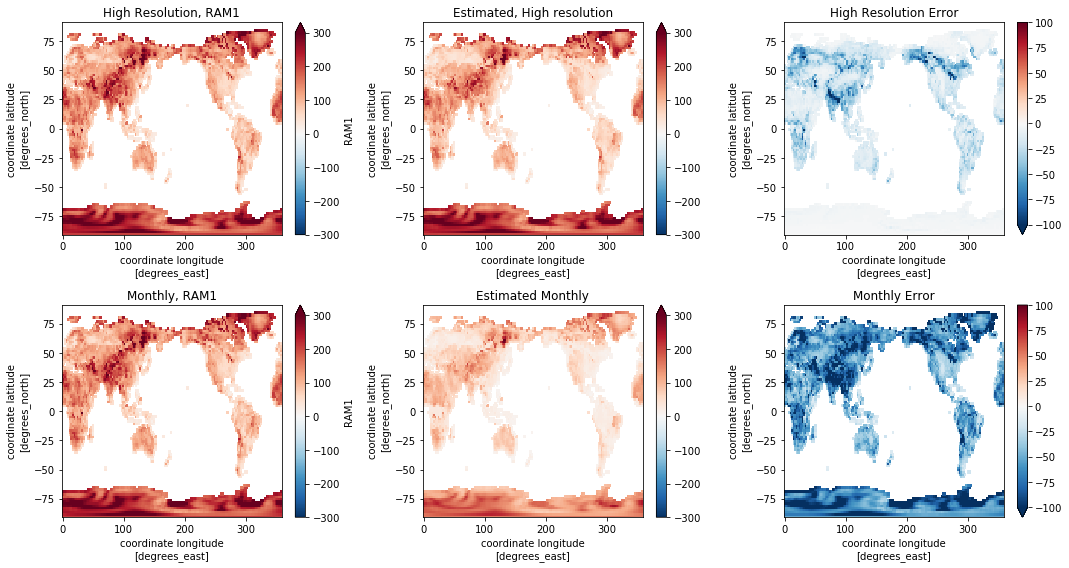

In [54]:
plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
actual_highres.plot(vmax=300, vmin=-300, cmap=plt.cm.RdBu_r)
plt.title('High Resolution, RAM1')
plt.subplot(2,3,2)
est_highres.plot(vmax=300, vmin=-300, cmap=plt.cm.RdBu_r)
plt.title('Estimated, High resolution')
plt.subplot(2,3,3)
error_highres.plot(vmax=100, vmin=-100, cmap=plt.cm.RdBu_r)
plt.title('High Resolution Error')
plt.subplot(2,3,4)
actual.plot(vmax=300, vmin=-300, cmap=plt.cm.RdBu_r)
plt.title('Monthly, RAM1')
plt.subplot(2,3,5)
est.plot(vmax=300, vmin=-300, cmap=plt.cm.RdBu_r)
plt.title('Estimated Monthly')
plt.subplot(2,3,6)
error.plot(vmax=100, vmin=-100, cmap=plt.cm.RdBu_r)
plt.title('Monthly Error')

plt.tight_layout()

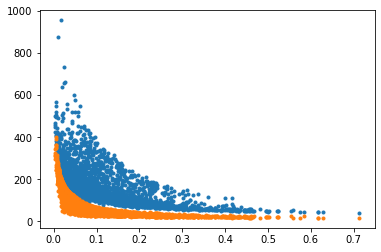

In [55]:
plt.plot(np.sqrt((ds1.TAUX*ds1.TAUX)+(ds1.TAUY*ds1.TAUY))[:,72,110],
         ds1.RAM1[:,72,110],'.')
plt.plot(np.sqrt((ds1.TAUX*ds1.TAUX)+(ds1.TAUY*ds1.TAUY))[:,72,110],
         rah2_highres[:,72,110],'.')

(0, 230)

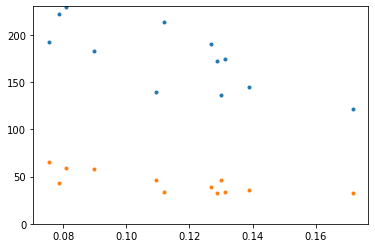

In [59]:
plt.plot(np.sqrt((ds.TAUX*ds.TAUX)+(ds.TAUY*ds.TAUY))[:,72,110],
         ds.RAM1[:,72,110],'.', label='actual')
plt.plot(np.sqrt((ds.TAUX*ds.TAUX)+(ds.TAUY*ds.TAUY))[:,72,110],
         rah2[:,72,110],'.', label='estimated')
plt.ylim([0,230])

# Compare both methods

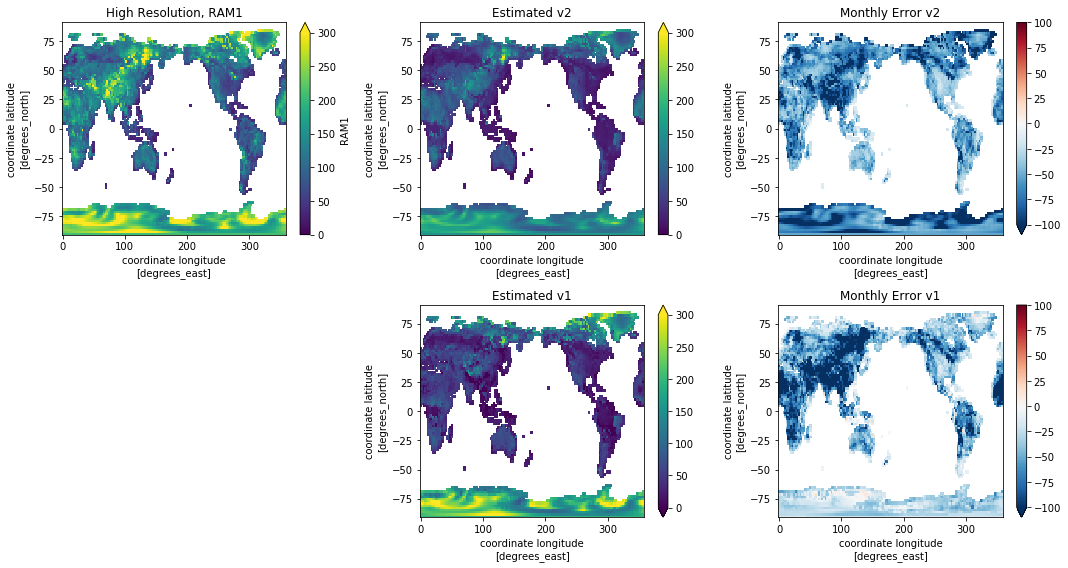

In [56]:
actual=ds.RAM1.mean(dim='time')
est2=rah2.mean(dim='time')
error2=est2-actual

est1=rah1.mean(dim='time')
error1=est1-actual

plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
actual_highres.plot(vmax=300, vmin=0, cmap=plt.cm.viridis)
plt.title('High Resolution, RAM1')
plt.subplot(2,3,2)
est2.plot(vmax=300, vmin=0, cmap=plt.cm.viridis)
plt.title('Estimated v2')
plt.subplot(2,3,3)
error2.plot(vmax=100, vmin=-100, cmap=plt.cm.RdBu_r)
plt.title('Monthly Error v2')

plt.subplot(2,3,5)
est1.plot(vmax=300, vmin=0, cmap=plt.cm.viridis)
plt.title('Estimated v1')
plt.subplot(2,3,6)
error1.plot(vmax=100, vmin=-100, cmap=plt.cm.RdBu_r)
plt.title('Monthly Error v1')

plt.tight_layout()

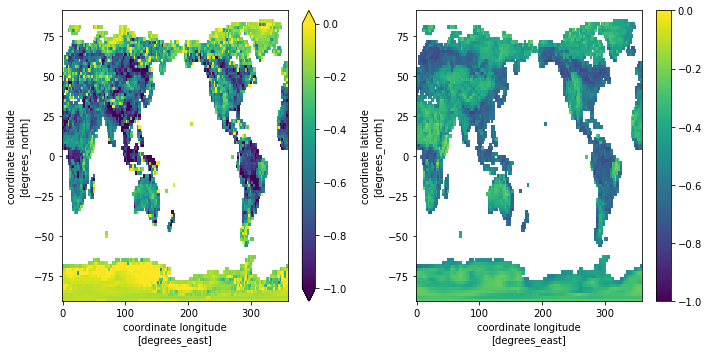

In [65]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
(error1/actual).plot(vmax=0, vmin=-1)
plt.subplot(1,2,2)
(error2/actual).plot(vmax=0, vmin=-1)
plt.tight_layout()

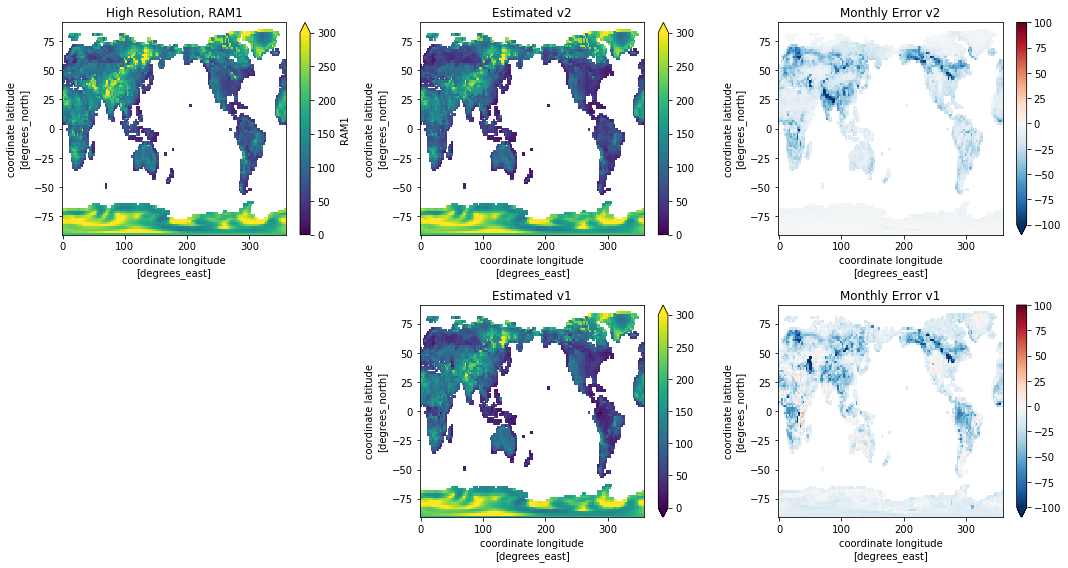

In [66]:
actual=ds1.RAM1.mean(dim='time')
est2=rah2_highres.mean(dim='time')
error2=est2-actual

est1=rah1_highres.mean(dim='time')
error1=est1-actual

plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
actual_highres.plot(vmax=300, vmin=0, cmap=plt.cm.viridis)
plt.title('High Resolution, RAM1')
plt.subplot(2,3,2)
est2.plot(vmax=300, vmin=0, cmap=plt.cm.viridis)
plt.title('Estimated v2')
plt.subplot(2,3,3)
error2.plot(vmax=100, vmin=-100, cmap=plt.cm.RdBu_r)
plt.title('Monthly Error v2')

plt.subplot(2,3,5)
est1.plot(vmax=300, vmin=0, cmap=plt.cm.viridis)
plt.title('Estimated v1')
plt.subplot(2,3,6)
error1.plot(vmax=100, vmin=-100, cmap=plt.cm.RdBu_r)
plt.title('Monthly Error v1')

plt.tight_layout()

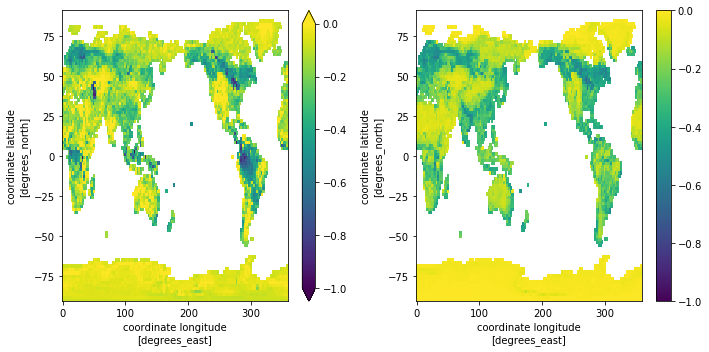

In [67]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
(error1/actual).plot(vmax=0, vmin=-1)
plt.subplot(1,2,2)
(error2/actual).plot(vmax=0, vmin=-1)
plt.tight_layout()

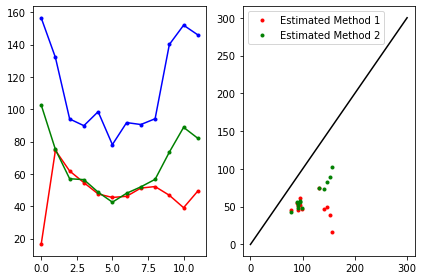

In [86]:
i=70#70
j=100#100
plt.subplot(1,2,1)
plt.plot(ds.RAM1[:,i,j,],'.-b', label='Actual')
plt.plot(rah1[:,i,j,],'.-r', label='Estimated Method 1')
plt.plot(rah2[:,i,j,],'.-g', label='Estimated Method 2')
plt.subplot(1,2,2)
plt.plot(ds.RAM1[:,i,j,],rah1[:,i,j,],'.r', label='Estimated Method 1')
plt.plot(ds.RAM1[:,i,j,],rah2[:,i,j,],'.g', label='Estimated Method 2')
plt.plot([0,300],[0,300],'-k')
plt.legend()
plt.tight_layout()
#plt.ylim([0,200])

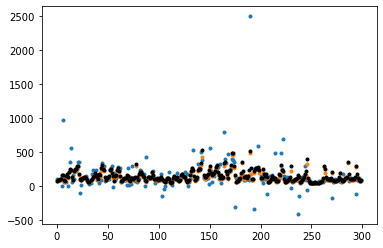

In [89]:
plt.plot(rah1_highres[0:300,i,j],'.', label='Method 1')
plt.plot(rah2_highres[0:300,i,j],'.', label='Method 2')
plt.plot(ds1.RAM1[0:300,i,j],'.k', label='Actual')

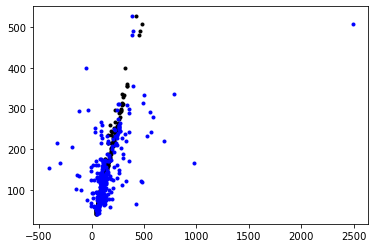

In [126]:
plt.plot(rah2_highres[0:300,i,j],ds1.RAM1[0:300,i,j],'.k', label='Actual')
plt.plot(rah1_highres[0:300,i,j],ds1.RAM1[0:300,i,j],'.b', label='Actual')

In [95]:
rho_highres_avg=calculate_rho(ds1.PBOT.load().rolling(time=(8*30)).mean(), 
                              ds1.TBOT.load().rolling(time=(8*30)).mean(), 
                              ds1.QBOT.load().rolling(time=(8*30)).mean())

In [121]:
rah2_v2=calculate_rah_from_tau(ds1.TAUX.load().rolling(time=(8*30)).mean(), 
                               ds1.TAUY.load().rolling(time=(8*30)).mean(), 
                               ds1.WIND.load().rolling(time=(8*30)).mean(), 
                               rho_highres_avg)


In [127]:
rah1_v2=calculate_rah_simple(ds1.TBOT, 
                             ds1.TSKIN, 
                             rho_highres, 
                             ds1.FSH.load().rolling(time=(8*30)).mean(), filter_on=True)


In [ ]:
#rho does not matter
# averaging WIND -> OVERESTIMATING rah
# averaging TAUX -> UNDERESTIMATING rah
# TAUY?

(0, 160)

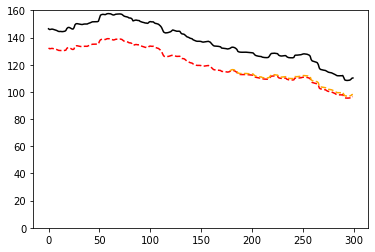

In [118]:
plt.plot(ds1.RAM1[:,i,j].load().rolling(time=(8*30)).mean()[300:600],'-k')
plt.plot(rah2_highres[:,i,j].load().rolling(time=(8*30)).mean()[300:600],'--r')
plt.plot(rah2_v2[:,i,j].load().rolling(time=(8*30)).mean()[300:600],'--',color='orange')
plt.ylim([0,160])

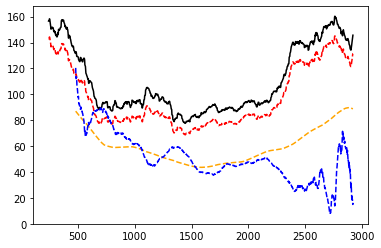

In [128]:
plt.plot(ds1.RAM1[:,i,j].load().rolling(time=(8*30)).mean(),'-k')
plt.plot(rah2_highres[:,i,j].load().rolling(time=(8*30)).mean(),'--r')
plt.plot(rah1_highres[:,i,j].load().rolling(time=(8*30)).mean(),'--',color='green')
plt.plot(rah2_v2[:,i,j].load().rolling(time=(8*30)).mean(),'--',color='orange')
plt.plot(rah1_v2[:,i,j].load().rolling(time=(8*30)).mean(),'--',color='blue')

# Other

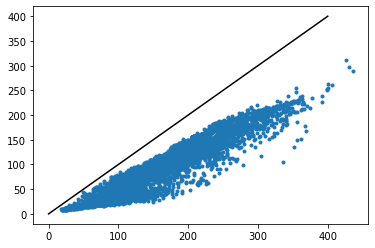

In [17]:
plt.plot(ds.RAM1.mean(dim='time').values.flatten(),
         ra_est2.mean(dim='time').values.flatten(),'.')
plt.plot([0,400],[0,400],'-k')

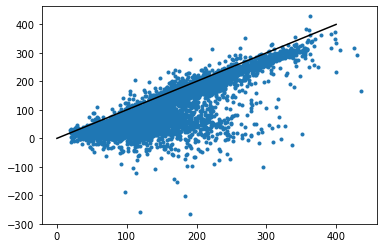

In [21]:
plt.plot(ds.RAM1.mean(dim='time').values.flatten(),
         rah_calculated.mean(dim='time').values.flatten(),'.')
plt.plot([0,400],[0,400],'-k')

In [6]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/offline_mechanism/')

from utils import *

In [118]:

rho_mean=calculate_rho(ds.PBOT.mean(dim='time'), ds.TBOT.mean(dim='time'), ds.QBOT.mean(dim='time'))

In [60]:
rah_calculated_mean=calculate_rah_simple(ds.TBOT.mean(dim='time'), 
                                         ds.TSKIN.mean(dim='time'), 
                                         rho_mean, 
                                         ds.FSH.mean(dim='time'), filter_on=True)

In [134]:
rah_calculated_mean1=calculate_rah_simple(ds.TBOT.mean(dim='time'), 
                                         ds.TSKIN.mean(dim='time'),#, 
                                         rho, # does not make a difference
                                         ds.FSH.mean(dim='time'), filter_on=True).mean(dim='time')

# if using average of FSH, OVERESTIMATES
# if using average of TBOT, OVERESTIMATES
# average rho does not matter

In [ ]:
Tau_all=np.sqrt((ds.TAUX*ds.TAUX)+(ds.TAUY*ds.TAUY))
rho=1
ra_est2=(rho*ds.WIND/Tau_all)
ra_est2_mean=ra_est2.mean(dim='time').load()

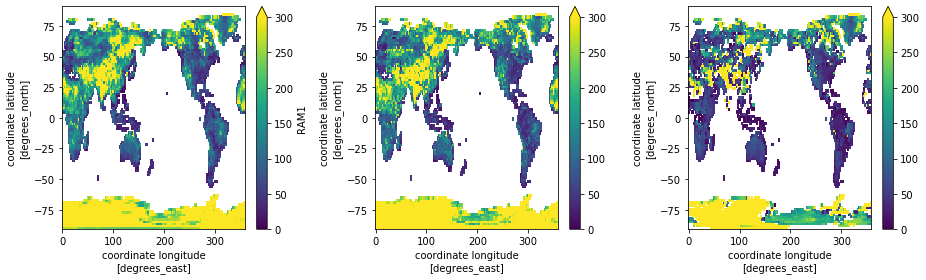

In [135]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
ds.RAM1.mean(dim='time').plot(vmin=0, vmax=300)
plt.subplot(1,3,2)
rah_calculated.mean(dim='time').plot(vmin=0, vmax=300)
plt.subplot(1,3,3)
rah_calculated_mean1.plot(vmin=0, vmax=300)
plt.tight_layout()

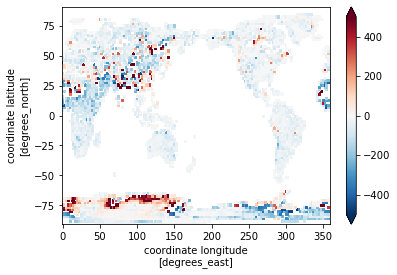

In [143]:
diff=rah_calculated_mean1-rah_calculated.mean(dim='time')
diff.plot(vmax=500)

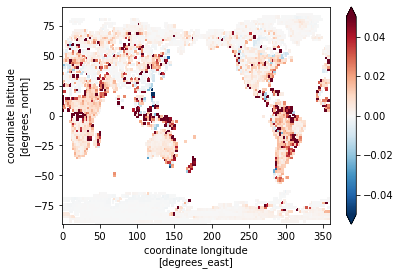

In [150]:
diff=1/rah_calculated_mean1-1/rah_calculated.mean(dim='time')
diff.plot(vmax=0.05)#vmax=500)

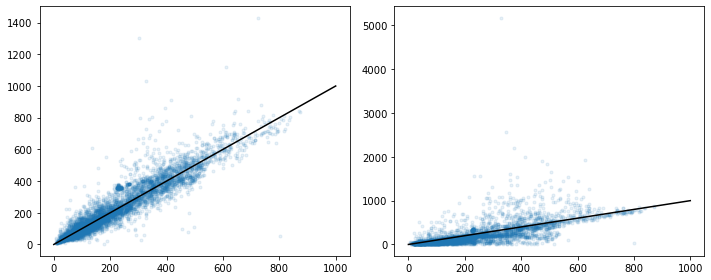

In [136]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ds.RAM1.mean(dim='time').values.flatten(),
        rah_calculated.mean(dim='time').values.flatten(),'.',alpha=0.1)
error1=(rah_calculated.mean(dim='time').values.flatten()-ds.RAM1.mean(dim='time').values.flatten())
plt.plot([0,1000],[0,1000],'-k')
plt.subplot(1,2,2)
plt.plot(ds.RAM1.mean(dim='time').values.flatten(),
        rah_calculated_mean1.values.flatten(),'.',alpha=0.1)
error2=(rah_calculated_mean1.values.flatten()-ds.RAM1.mean(dim='time').values.flatten())
plt.plot([0,1000],[0,1000],'-k')
plt.tight_layout()

(array([2.273e+03, 1.101e+03, 5.370e+02, 2.290e+02, 1.420e+02, 1.000e+02,
        6.300e+01, 4.300e+01, 2.600e+01, 1.800e+01, 1.200e+01, 1.000e+01,
        1.500e+01, 1.100e+01, 5.000e+00, 7.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950]),
 <a list of 19 Patch objects>)

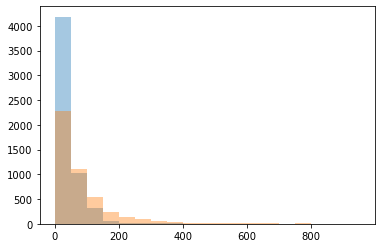

In [137]:
plt.hist(np.abs(error1),bins=np.arange(0,1000,50),alpha=0.4, label='Each time step')
plt.hist(np.abs(error2),bins=np.arange(0,1000,50),alpha=0.4, label='Averages')

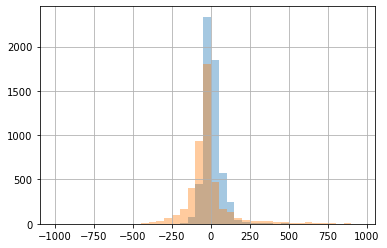

In [139]:
plt.hist((error1),bins=np.arange(-1000,1000,50),alpha=0.4, label='Each time step')
plt.hist((error2),bins=np.arange(-1000,1000,50),alpha=0.4, label='Averages')
plt.grid()

In [ ]:
rah_cal

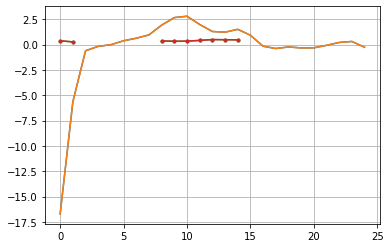

In [46]:
plt.plot(ds.FSH[:,i,j])
plt.plot(ds.FSH[:,i,j])
plt.plot(rah_calculated.where(np.abs(ds.FSH)>1)[:,i,j]/1000,'.-')
plt.plot(rah_calculated.where(np.abs(ds.FSH)>1)[:,i,j]/1000,'.-')
plt.grid()

210.68394
192.5581


(0, 1000)

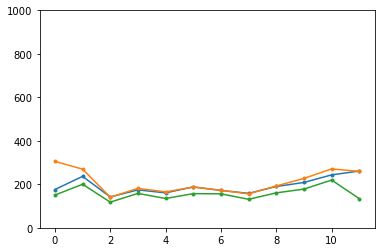

In [8]:
i=0#70
j=0#100
plt.plot(rah_calculated[:,i,j],'.-')
#plt.plot(rah_calculated[:,i,j],'.-')
plt.plot(ds.RAM1[:,i,j],'.-')
plt.plot(ra_est2[:,i,j],'.-')

print(np.nanmean(ds.RAM1[:,i,j]))
print(np.nanmean(rah_calculated[:,i,j]))
plt.ylim([0,1000])

In [ ]:
print(1)

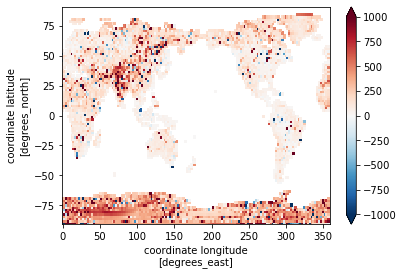

In [13]:
rah_calculated.mean(dim='time').plot(vmax=1000)

# Look at rs

In [112]:
def calculate_raw_simple(Ts, P, qa, LH, rho):
    LH_thresh=5
    
    SHR_CONST_LATICE  = 3.337e5#latent heat of fusion      ~ J/kg
    SHR_CONST_LATVAP  = 2.501e6#latent heat of evaporation ~ J/kg
    SHR_CONST_LATSUB  = SHR_CONST_LATICE + SHR_CONST_LATVAP # latent heat of sublimation ~ J/kg

    qsat_Ts=calculate_qsat(Ts, P)
    qdiff=qsat_Ts-qa
    raw=rho*CONSTANT_Lv*qdiff/LH.where(np.abs(LH)>LH_thresh)
    
    raw_sub=rho*SHR_CONST_LATSUB*(qsat_Ts-qa)/LH.where(np.abs(LH)>LH_thresh)
    raw_combo=raw.where(Ts>273.15,raw_sub).load()
    
    return raw_combo

In [113]:
raw_est=calculate_raw_simple(ds1.TSKIN, ds1.PBOT, ds1.QBOT, ds1.EFLX_LH_TOT, rho_highres)

(-10, 10)

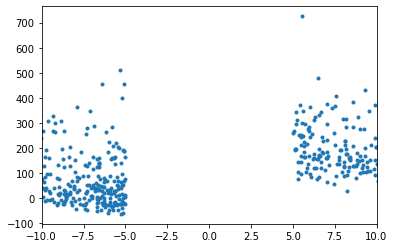

In [114]:
plt.plot(ds1.EFLX_LH_TOT[:,85,110],raw_est[:,85,110],'.')
plt.xlim([-10,10])

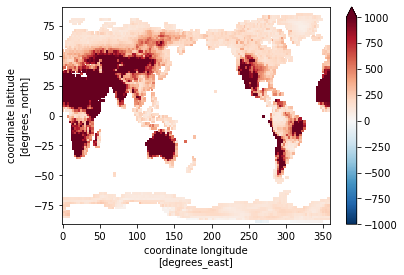

In [116]:
raw_est.mean(dim='time').plot(vmax=1000)

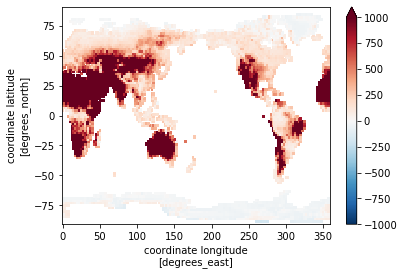

In [121]:
(raw_est-rah1_highres).mean(dim='time').plot(vmax=1000)

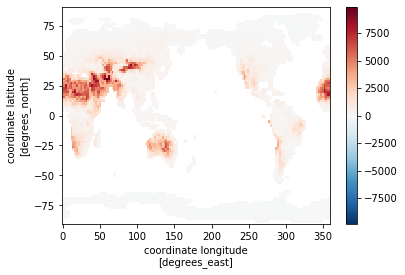

In [120]:
(raw_est.mean(dim='time')-rah1_highres.mean(dim='time')).plot()

In [108]:
raw_est=raw_est.where(raw_est>0).where(raw_est<10000)

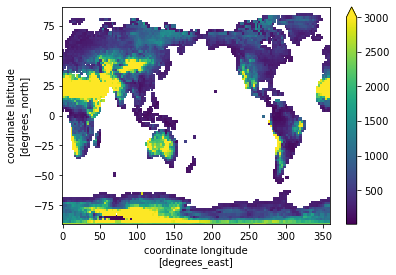

In [78]:
raw_est.mean(dim='time').plot(vmax=3000)